In [281]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import tweepy
import io
import os
import json
import matplotlib.pyplot as plt
from timeit import default_timer as timer

# Gather

In [282]:
#Create 'raw-data' folder
folder_name = 'raw-data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [283]:
archive = pd.read_csv('raw-data/twitter-archive-enhanced.csv')

In [284]:
#Download image_predictions.tsv from the url
url =  "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

In [285]:
img_predit = pd.read_csv(io.StringIO(response.content.decode('utf-8')), sep='\t')

In [286]:
img_predit.to_csv('raw-data/image-predictions.csv')

In [448]:
consumer_key = 'JcrI6rjL8V9htFTOrSvdn1SJk'
consumer_secret = '7GCzjEvuHghj2mkf7e6SnwLavz3UJCjtRVCLWjTwM7M1wxxjF3'
access_token = '707089529543401472-NNY42Am0BwX2hL7iQfZhrLP3FzKOIWJ' 
access_secret = 'aUpj7Np57ZszDVJZpK4IDMmszMMTAIh4Jdgvs9wHryhU4'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [449]:
start = timer()
i=0
for tweet_id in archive['tweet_id']:
    if i<100000:
        with open (os.path.join(folder_name,
                           'tweet_json.txt'), mode='a') as file:
            try:
                json.dump(api.get_status(tweet_id,
                                         tweet_mode='extended',
                                         wait_on_rate_limit=True,
                                         wait_on_rate_limit_notify=True)._json, file)
                file.write('\n')
                #print('Tweet record with ID {} was written to file'.format(tweet_id))
            except:
                print('No status found with ID {}.'.format(tweet_id))
    i = i+1
end = timer()
print('Total runing time of the for loop is {}s'.format(end - start))

No status found with ID 888202515573088257.
No status found with ID 873697596434513921.
No status found with ID 872668790621863937.
No status found with ID 872261713294495745.
No status found with ID 869988702071779329.
No status found with ID 866816280283807744.
No status found with ID 861769973181624320.
No status found with ID 856602993587888130.
No status found with ID 845459076796616705.
No status found with ID 844704788403113984.
No status found with ID 842892208864923648.
No status found with ID 837012587749474308.
No status found with ID 827228250799742977.
No status found with ID 812747805718642688.
No status found with ID 802247111496568832.
No status found with ID 775096608509886464.
No status found with ID 770743923962707968.


Rate limit reached. Sleeping for: 681


No status found with ID 754011816964026368.
No status found with ID 680055455951884288.


Rate limit reached. Sleeping for: 680


Total runing time of the for loop is 2031.9761412258958s


In [450]:
with open ('raw-data/tweet_json.txt') as file:
    lines = file.readlines()
    tweet_json = pd.DataFrame()
    for line in lines:
        tweet_json = tweet_json.append(json.loads(line), ignore_index=True)

# Access and Clean

## Twitter-Archive Table

In [290]:
#Set jupyter notebook to display full text
pd.set_option('display.max_colwidth', -1)

In [416]:
archive_clean = archive.copy()

In [292]:
archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

#### Looks like all the column names are in good format

In [293]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

There is no null values for `tweet_id, timestamp, text, rating_numerator, rating_denominator`, we don't have to drop any rows for the time being.

In [294]:
#Check if there is duplicated `tweet_id`
(archive_clean.duplicated(subset='tweet_id')).any()

False

Appearantly there is no duplicated `tweet_id`

### Quality Issue #1 Drop the re-tweet rows

#### Define
Select only rows where `retweeted_status_id` is `NaN` 

#### Code

In [418]:
archive_clean = archive_clean[archive_clean['retweeted_status_id'].isnull()]

#### Test
Make sure the `retweeted_status_user_id` and `retweeted_status_timestamp` are all `NaN` as well

In [296]:
#Make sure all the 'retweeted_status_user_id' is NaN
archive_clean['retweeted_status_user_id'].isnull().all()

True

In [297]:
#Make sure all the 'retweeted_status_timestamp' is NaN
archive_clean['retweeted_status_timestamp'].isnull().all()

True

### Quality Issue #2 Drop rows without pictures

For the breed prediction neural network to work properly, a image is required for each tweet. As a result I am going to drop rows without pictures

#### Define
Keep rows which contains `https://twitter.com/dog_rates/status/../photo/1` in the `expanded_url` column, there might be other strings before or after the photo url, replace NaN with False value.

#### Code

In [298]:
has_img = archive_clean['expanded_urls'].str.match(r'.*,?https://twitter.com/dog_rates/status/\d{18}/photo/1,?.*', case=False, na=False)

In [299]:
archive_clean[~has_img].to_csv('no_img.csv')

In [419]:
archive_clean = archive_clean[has_img]

#### Test
Physically check the `no_img.csv` file with excel and make sure I didn't drop any rows with image

In [420]:
#Make sure all rows left has image url, this should read True
archive_clean['expanded_urls'].str.match(r'.*,?https://twitter.com/dog_rates/status/\d{18}/photo/1,?.*', case=False, na=False).all()

True

### Quality Issue #3: check if any tweets are after 1-Aug-2017

#### Define
Convert timestamp column to date-time object, then sort values to see if any time stamp is after 1-Aug-2017

#### Code

In [302]:
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

#### Test
It looks like no time stamps are after 1-Aug-2017

In [303]:
#Check if any timestand equal or after 2-Aug-2017, this should read False
(archive_clean['timestamp'] >= '2-Aug-2017').any()

False

### Quality Issue #4: some `rating_numerator` and `rating_denominator` are parsed incorrectly

#### Part 1
Some of the values in rating_denominator are not 10

In [304]:
archive_clean.query('rating_denominator != 10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690886586372/photo/1,80,80,None,None,None,None,None
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395643068416/photo/1,45,50,None,None,None,None,None
1351,704054845121142784,NaN,NaN,2016-02-28 21:25:30,"<a href=""http://twitter.com/download/iphone"" rel=""no

#### Out of those records, those denominotors that are multiples of 10 are just result of multiple doges. I just have to drop those rows with odd denominators that are not multiples of 10

#### Define
Drop rows with `rating_denominators` that result a remainder other than 0 when devided by 10

#### Code

In [421]:
archive_clean = archive_clean.query('rating_denominator % 10 == 0')

#### Test
Make sure all `rating_denominators` are multiples of 10

In [306]:
#This shuold read True
((archive_clean['rating_denominator'] % 10) == 0).all()

True

#### Part2 
Some rating result are out of range

Insert a new column `rating_result` as a result of `rating_numerator` devided by `rating_denominator`

In [422]:
archive_clean['rating_result'] = archive_clean['rating_numerator'] / archive_clean['rating_denominator']

Take a look at all the `rating_result`

In [308]:
archive_clean['rating_result'].value_counts().sort_index()

0.0      2  
0.1      4  
0.2      10 
0.3      19 
0.4      14 
0.5      33 
0.6      32 
0.7      51 
0.8      93 
0.9      149
1.0      415
1.1      392
1.2      433
1.3      235
1.4      29 
2.6      1  
2.7      1  
7.5      1  
42.0     1  
177.6    1  
Name: rating_result, dtype: int64

In [309]:
archive_clean.query('rating_result <= 0.1')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating_result
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1",0,10,None,None,None,None,None,0.0
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459439529985/photo/1,0,10,None,None,None,None,None,0.0
1869,675153376133427200,NaN,NaN,2015-12-11 03:21:23,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",What kind of person sends in a picture without a dog in it? 1/10 just because that's a nice table https://t.co/RDXCfk8hK0,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675153376133427200/photo/1,1,10,None,None,None,None,None,0.1
2091,670783437142401025,NaN,NaN,2015-11-29 01:56:48,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Flamboyant pup here. Probably poisonous. Won't eat kibble. Doesn't bark. Slow af. Petting doesn't look fun. 1/10 https://t.co/jxukeh2BeO,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670783437142401025/photo/1,1,10,None,None,None,None,None,0.1
2261,667549055577362432,NaN,NaN,2015-11-20 03:44:31,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Never seen dog like this. Breathes heavy. Tilts head in a pattern. No bark. Shitty at fetch. Not even cordless. 1/10 https://t.co/i9iSGNn3fx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667549055577362432/photo/1,1,10,None,None,None,None,None,0.1
2338,666104133288665088,NaN,NaN,2015-11-16 04:02:55,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1,10,None,None,None,None,None,0.1


Those small ratings are parsed properly.

Now take a look at the high `rating_result`

In [310]:
archive_clean.query('rating_result >= 2.6')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating_result
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None,7.5
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None,2.7
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,Atticus,None,None,None,None,177.6
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,None,None,None,None,2.6
2074,670842764863651840,NaN,NaN,2015-11-29 05:52:33,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670842764863651840/photo/1,420,10,None,None,None,None,None,42.0


It apprears they are eith parsed incorrectly, so the auther just gives a absurd number, it is safe to drop those five rows.

#### Code

In [423]:
archive_clean = archive_clean.query('rating_result < 2.6')

#### Test 
Make sure all the `rating_result` less than 2.6

In [424]:
#This should read True
(archive_clean['rating_result'] < 2.6).all()

True

### Quality issue #5: `tweet_id` should be changed to data type `str`

In [425]:
archive_clean['tweet_id'] = archive_clean['tweet_id'].astype('str')

In [314]:
archive_clean.dtypes

tweet_id                      object        
in_reply_to_status_id         float64       
in_reply_to_user_id           float64       
timestamp                     datetime64[ns]
source                        object        
text                          object        
retweeted_status_id           float64       
retweeted_status_user_id      float64       
retweeted_status_timestamp    object        
expanded_urls                 object        
rating_numerator              int64         
rating_denominator            int64         
name                          object        
doggo                         object        
floofer                       object        
pupper                        object        
puppo                         object        
rating_result                 float64       
dtype: object

### Tidy issue #1: the columns `'doggo', 'floofer', 'pupper', 'puppo'` are values of variable `stage`

#### Define
Convert `None` to 0, `doggo', 'floofer', 'pupper', 'puppo'` to 1 in their own columns, drop rows with multiple nonezero values

#### Code

In [426]:
cols = ['doggo', 'floofer', 'pupper', 'puppo']

In [427]:
#Replace 'None' with 0, other values with 1
archive_clean[cols] = archive_clean[cols].replace({'None':0, 'doggo':1, 'pupper':1, 'puppo':1, 'floofer':1})

In [428]:
archive_clean[cols].sum(axis=1).value_counts()

0    1625
1     276
2      10
dtype: int64

There are 10 rows with two stages, which is a very small sample of this data set. As a result, I am going classify them as outlier and drop them.

In [429]:
archive_clean = archive_clean[archive_clean[cols].sum(axis=1) < 2]

In [319]:
#Make sure the outliers have been dropped, this should return nothing
archive_clean[(archive_clean[cols].sum(axis=1)) > 1]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating_result


Create a new column `stage`, the values should be NaN if none of the four columns is 1, or the column name if it is 1. 

In [430]:
archive_clean['stage'] = archive_clean[cols].apply(lambda x: np.NaN if x.sum()==0 else x.idxmax(), axis=1)

#### Test
Make sure the 1s in `'doggo', 'floofer', 'pupper', 'puppo'` columns match their columns in the `stage` column

In [322]:
#THis should read True
((sum(archive_clean['pupper']) == archive_clean['stage'].value_counts()['pupper']) 
& (sum(archive_clean['doggo']) == archive_clean['stage'].value_counts()['doggo']) 
& (sum(archive_clean['puppo']) == archive_clean['stage'].value_counts()['puppo'])
& (sum(archive_clean['floofer'])== archive_clean['stage'].value_counts()['floofer']))

True

### Tidy issue #2: create a new column and remove unnecessary columns

Create a new column `multi_dog` to flag if there are more than one dog in the picture

In [432]:
archive_clean['multi_dog'] = archive_clean['rating_denominator'].apply(lambda x: True if x > 10 else False)

In [433]:
cols_keep = ['tweet_id', 'rating_result', 'stage', 'multi_dog']

In [434]:
archive_clean = archive_clean[cols_keep]

# tweet_json table

In [326]:
#Adjust jupyter notebook to normal display 
pd.set_option('display.max_colwidth', 50)

In [451]:
tweet_json_clean = tweet_json.copy()

In [328]:
tweet_json_clean.dtypes

contributors                      object
coordinates                       object
created_at                        object
display_text_range                object
entities                          object
extended_entities                 object
favorite_count                   float64
favorited                        float64
full_text                         object
geo                               object
id                               float64
id_str                            object
in_reply_to_screen_name           object
in_reply_to_status_id             object
in_reply_to_status_id_str         object
in_reply_to_user_id               object
in_reply_to_user_id_str           object
is_quote_status                  float64
lang                              object
place                             object
possibly_sensitive               float64
possibly_sensitive_appealable    float64
retweet_count                    float64
retweeted                        float64
source          

### Quality Issue #1: `favorite_count` , `retweet_count` should be converted to integer

#### Code

In [453]:
tweet_json_clean['favorite_count'] = tweet_json_clean['favorite_count'].astype('int64')

In [454]:
tweet_json_clean['retweet_count'] = tweet_json_clean['retweet_count'].astype('int64')

#### Test

In [455]:
tweet_json_clean.dtypes

contributors                      object
coordinates                       object
created_at                        object
display_text_range                object
entities                          object
extended_entities                 object
favorite_count                     int64
favorited                        float64
full_text                         object
geo                               object
id                               float64
id_str                            object
in_reply_to_screen_name           object
in_reply_to_status_id             object
in_reply_to_status_id_str         object
in_reply_to_user_id               object
in_reply_to_user_id_str           object
is_quote_status                  float64
lang                              object
place                             object
possibly_sensitive               float64
possibly_sensitive_appealable    float64
retweet_count                      int64
retweeted                        float64
source          

### Tidy issue #1: unnessery table
This table describe the attributes of each tweet_id, which is the same as `archive_clean` table, I will merge `favorite_count` and `retweet_count` columns to `archive_clean` table

#### Define
Use merge function

#### Code

In [459]:
cols_merge = ['id_str', 'favorite_count', 'retweet_count']

In [460]:
tweet_merge = archive_clean.merge(tweet_json_clean[cols_merge], how='left', left_on='tweet_id', right_on='id_str')

In [461]:
sum(tweet_merge['id_str'].isnull())

4

Only 4 rows in `archive_clean` can't be matched with `tweet_json_clean` table, I will drop them

In [463]:
tweet_merge = tweet_merge[tweet_merge['id_str'].notnull()]

In [464]:
#Drop 'id_str' because it duplicates 'tweet_id'
tweet_merge = tweet_merge.drop('id_str', axis=1)

#### Test
Make sure `favorite_count` and `retweet_count` columns are without null values

In [466]:
#This should read 0
sum(tweet_merge['favorite_count'].isnull()) + sum(tweet_merge['retweet_count'].isnull())

0

## img_predit table

In [467]:
img_predit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          1532 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [468]:
img_predit.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


This table describe the attributes of each tweet_id, which is the same as `tweet_merge` table, I will merge `p1` column to `tweet_merge` table. 

### Quality issue #1: wrong data types
To merge this table with `tweet_merge` table, we need convert `tweet_id` column to data type character

In [469]:
img_predit['tweet_id'] = img_predit['tweet_id'].astype('str')

### Quality issue #2: mixed lower and upper case letters for `p1` output
Some of them start with upper case letter and some of them don't

In [470]:
img_predit['p1'] = img_predit['p1'].str.lower()

All we need from this table is the dog breed. I will take `p1`, which is the most confident choice, as the result of breed prediction. I will replace values in `p1` with NaN if it is the result is not a dog.

### Tidy issue #1: unnessery table
This table describe the attributes of each tweet_id, which is the same as `tweet_merge` table, I will merge `p1` column to `tweet_merge` table

#### Define
Use .loc method to replace all values in `p1` column to NaN


#### Code

In [471]:
img_predit.loc[~img_predit['p1_dog'], 'p1'] = np.NaN

#### Test

In [472]:
#This should read True
all(img_predit[~img_predit['p1_dog']]['p1'].isnull())

True

Merge `p1` column with `tweet_merge` table

In [473]:
tweet_merge = tweet_merge.merge(img_predit[['tweet_id', 'p1']], how='left', on='tweet_id')

In [474]:
tweet_merge = tweet_merge.rename(columns={'p1':'breed'})

In [475]:
tweet_merge.head()

,tweet_id,rating_result,stage,multi_dog,favorite_count,retweet_count,breed
0,892420643555336193,1.3,NaN,False,37557.0,8192.0,NaN
1,892177421306343426,1.3,NaN,False,32281.0,6059.0,chihuahua
2,891815181378084864,1.2,NaN,False,24318.0,4008.0,chihuahua
3,891689557279858688,1.3,NaN,False,40906.0,8339.0,NaN
4,891327558926688256,1.2,NaN,False,39101.0,9040.0,basset


In [477]:
tweet_merge.to_csv('twitter_archive_master.csv', index=False)

# Analysis

In [479]:
stage_rating = tweet_merge.groupby('stage')['rating_result'].mean()

In [480]:
sns.set(style="whitegrid")

In [481]:
base_color = sns.color_palette()[0]

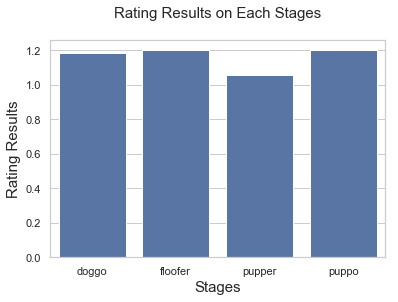

In [482]:
ax1 = sns.barplot(stage_rating.index, stage_rating.values, color=base_color)
ax1.set_title('Rating Results on Each Stages\n', fontsize=15)
ax1.set_xlabel('Stages', size=15)
ax1.set_ylabel('Rating Results', size=15);

In [483]:
stage_popularity = tweet_merge.groupby('stage')[['favorite_count','retweet_count']].mean()

In [484]:
stage_popularity = stage_popularity.reset_index()

In [485]:
stage_popularity = pd.melt(stage_popularity, 'stage')

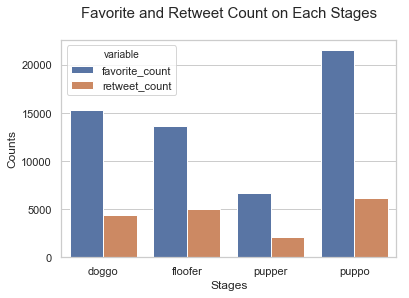

In [486]:
ax2 = sns.barplot(x='stage', y='value', hue='variable', data=stage_popularity)
ax2.set_title('Favorite and Retweet Count on Each Stages\n', fontsize=15)
ax2.set_xlabel('Stages')
ax2.set_ylabel('Counts');

## Insight1
The puppo stage is the most popular stage in terms of rating result, favorate_count and retweet_count. i.e. it is the favorite choice of the rater and audience. In contrast, pupper stage is the least popular stage.

In [487]:
breed_rating_top10 = tweet_merge.groupby('breed')['rating_result'].mean().sort_values(ascending=False)[:10].reset_index()

In [488]:
breed_favorite_top10 = tweet_merge.groupby('breed')['favorite_count'].mean().sort_values(ascending=False)[:10].reset_index()

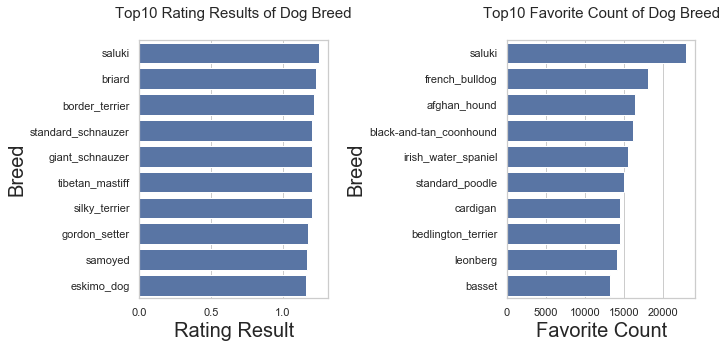

In [489]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.barplot(y='breed', x='rating_result', data=breed_rating_top10, color=base_color, ax=ax[0])
#ax[0].set_xticklabels(breed_rating_top10['breed'], rotation=90, size=20)
ax[0].set_ylabel('Breed', size=20)
ax[0].set_xlabel('Rating Result', size=20)
ax[0].set_title('Top10 Rating Results of Dog Breed\n', size=15)
sns.barplot(y='breed', x='favorite_count', data=breed_favorite_top10, color=base_color, ax=ax[1])
#ax[1].set_xticklabels(breed_favorite_top10['breed'], rotation=90, size=20)
ax[1].set_ylabel('Breed', size=20)
ax[1].set_xlabel('Favorite Count', size=20)
ax[1].set_title('Top10 Favorite Count of Dog Breed\n', size=15)
plt.tight_layout();

## Insight2
The saluki breed was the most favored breed by both rater and audience. It enjoys the highest rating result and favorite count.

In [490]:
tweet_merge.head(1)

,tweet_id,rating_result,stage,multi_dog,favorite_count,retweet_count,breed
0,892420643555336193,1.3,NaN,False,37557.0,8192.0,NaN


In [491]:
multi_dog = tweet_merge.groupby('multi_dog').mean().reset_index().melt('multi_dog')

In [492]:
multi_dog_rating = multi_dog.query('variable == "rating_result"')

In [493]:
multi_dog_rating

,multi_dog,variable,value
0,False,rating_result,1.048992
1,True,rating_result,1.030769


In [494]:
multi_dog_other = multi_dog.query('(variable == "favorite_count") | (variable == "retweet_count")')

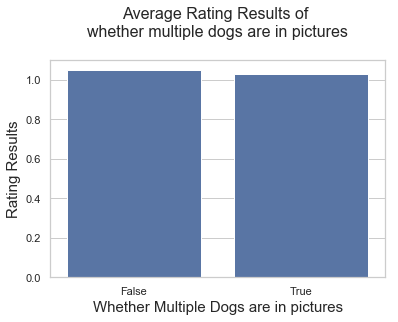

In [495]:
ax3 = sns.barplot(x='multi_dog', y='value', data=multi_dog_rating, color=base_color)
ax3.set_title('Average Rating Results of \nwhether multiple dogs are in pictures\n', fontsize=16)
ax3.set_xlabel('Whether Multiple Dogs are in pictures', size=15)
ax3.set_ylabel('Rating Results', size=15);

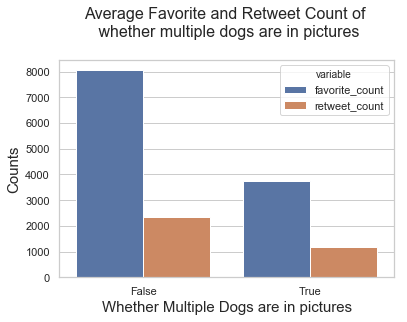

In [496]:
ax4 = sns.barplot(x='multi_dog', y='value', hue='variable', data=multi_dog_other)
ax4.set_title('Average Favorite and Retweet Count of \n whether multiple dogs are in pictures\n', size=16)
ax4.set_xlabel('Whether Multiple Dogs are in pictures', size=15)
ax4.set_ylabel('Counts', size=15);

## Insight3
The pictures with one dog enjoy a slightly higher rating from the rater, and overwhelmingly better acceptence from the audience.

# Limitations

### 1. Some of the group sizes are small compared to the whole sample

In [497]:
tweet_merge.query('breed == "saluki"').shape[0]

4

The `saluki` breed only have 4 samples

In [498]:
tweet_merge.query('multi_dog == True').shape[0]

13

There are only 13 pictures with multiple dogs in it.

### 2. The breed tag of each tweet was predited by  a neural network, the accuracy of the predition affects the result of the analysis derived from the breed

### 3. The stage tag only cover a small portion of all the samples

In [503]:
tweet_merge['stage'].isnull().mean()

0.8545071164997364

Over 85% of tweets don't have a stage tag, which make analysis based on dog stage less conclusive.